In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

# **Chuẩn bị dữ liệu**

In [3]:
import os
import random
import shutil

def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.2, 0.1)):
    # Create directories if they don't exist
    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Get list of all files in the source directory
    files = os.listdir(source_dir)
    # Shuffle the files
    random.shuffle(files)

    # Calculate split indices
    total_files = len(files)
    train_split = int(total_files * split_ratio[0])
    val_split = int(total_files * split_ratio[1])
    test_split = total_files - train_split - val_split

    # Split files into train, val, and test sets
    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))

# Example usage
source_directory = '/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/images'
train_directory = '/content/images/train'
val_directory = '/content/images/val'
test_directory = '/content/images/test'

split_data(source_directory, train_directory, val_directory, test_directory)


In [4]:
df=pd.read_csv('/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/faces.csv')
df['class'] = 'face'
df.columns = ['filename','width','height','xmin','ymin','xmax','ymax','class']
df = df[['filename','class','width', 'height','xmin','ymin','xmax','ymax']]

In [5]:
df.head()

filename class  width  height  xmin  ymin  xmax  ymax
0  00001722.jpg  face   1333    2000   490   320   687   664
1  00001044.jpg  face   2000    1333   791   119  1200   436
2  00001050.jpg  face    667    1000   304   155   407   331
3  00001736.jpg  face    626     417   147    14   519   303
4  00003121.jpg  face    626     418   462    60   599   166

In [6]:
df.shape

(3350, 8)

In [7]:
df.isnull().sum()

filename    0
class       0
width       0
height      0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [8]:
labels_dir = '/content/labels'

# Create the labels directory if it doesn't exist
if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)

# Subdirectories within labels directory
train_dir = os.path.join(labels_dir, 'train')
val_dir = os.path.join(labels_dir, 'val')
test_directory = os.path.join(labels_dir, 'test')
# Create train, val, and test directories within labels directory
for directory in [train_dir, val_dir,test_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [9]:
train_dir = '/content/images/train'
val_dir = '/content/images/val'
test_directory = '/content/images/test'
# Function to get filenames in a directory
def get_filenames_in_dir(directory):
    return set(os.listdir(directory))

# Get filenames in each directory
train_filenames = get_filenames_in_dir(train_dir)
val_filenames = get_filenames_in_dir(val_dir)
test_filenames = get_filenames_in_dir(test_directory)
# Filter DataFrame based on filenames
train_df = df[df['filename'].isin(train_filenames)]
val_df = df[df['filename'].isin(val_filenames)]
test_df = df[df['filename'].isin(test_filenames)]

In [10]:
def convert_to_yolo(df, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Function to convert bounding box coordinates to YOLO format
    def convert_to_yolo_format(width, height, xmin, ymin, xmax, ymax):
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height
        return x_center, y_center, box_width, box_height

    # Loop over the DataFrame and create YOLO format .txt files
    for index, row in df.iterrows():
        filename = row['filename']
        width = row['width']
        height = row['height']
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']

        x_center, y_center, box_width, box_height = convert_to_yolo_format(width, height, xmin, ymin, xmax, ymax)

        # Write YOLO format data to a .txt file
        output_file = os.path.join(output_dir, os.path.splitext(filename)[0] + ".txt")
        with open(output_file, 'w') as f:
            f.write(f"0 {x_center} {y_center} {box_width} {box_height}\n")

    print("YOLO format .txt files created successfully.")


convert_to_yolo(val_df, '/content/labels/val')
convert_to_yolo(train_df, '/content/labels/train')
convert_to_yolo(test_df, '/content/labels/test')

YOLO format .txt files created successfully.
YOLO format .txt files created successfully.
YOLO format .txt files created successfully.


In [11]:
import yaml

data = {
    'train': '/content/images/train',
    'val': '/content/images/val',
    'nc': 1,
    'names': {
        '0': 'face'
    }
}

with open('data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print("YAML file 'data.yaml' created successfully.")

YAML file 'data.yaml' created successfully.


In [12]:
!pip install ultralytics
!pip install -U ipywidgets

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.3/78.2 GB disk)


In [13]:
model = YOLO("yolov8m.pt")

# Display model information (optional)
model.info()


KQ = model.train(data='/content/data.yaml', epochs=20,imgsz=160,batch=16, patience=5)

100%|██████████| 49.7M/49.7M [00:00<00:00, 273MB/s]


YOLOv8m summary: 295 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=160, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 79.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 27.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/labels/train... 1542 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1542/1542 [00:04<00:00, 368.29it/s]


train: New cache created: /content/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/labels/val... 440 images, 0 backgrounds, 0 corrupt: 100%|██████████| 440/440 [00:01<00:00, 269.52it/s]


val: New cache created: /content/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 160 train, 160 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/97 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/20      1.64G      2.075      1.723      1.539         11        160: 100%|██████████| 97/97 [00:47<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.03s/it]

                   all        440        440      0.112      0.132     0.0334     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.19G      1.905      1.478      1.493         14        160: 100%|██████████| 97/97 [00:46<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:11<00:00,  1.17it/s]

                   all        440        440       0.12      0.541     0.0884     0.0391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.29G      1.857      1.473      1.463         10        160: 100%|██████████| 97/97 [00:51<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.01it/s]

                   all        440        440      0.538      0.539       0.53      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.29G      1.825      1.478      1.445         17        160: 100%|██████████| 97/97 [00:52<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.04it/s]

                   all        440        440       0.38      0.357      0.253      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.29G      1.788      1.385      1.408         10        160: 100%|██████████| 97/97 [00:44<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]

                   all        440        440      0.672      0.526      0.566      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       1.2G      1.703      1.332      1.342         18        160: 100%|██████████| 97/97 [00:42<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]

                   all        440        440      0.725      0.643      0.669      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.29G      1.633      1.264      1.339         15        160: 100%|██████████| 97/97 [00:44<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]

                   all        440        440      0.613      0.662      0.663       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.29G      1.586      1.225      1.322         11        160: 100%|██████████| 97/97 [00:43<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]

                   all        440        440      0.755      0.708      0.781      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.29G      1.536      1.181      1.278         13        160: 100%|██████████| 97/97 [00:42<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        440        440      0.736      0.689      0.755      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.19G      1.538      1.156       1.29          8        160: 100%|██████████| 97/97 [00:42<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        440        440      0.858       0.68      0.822      0.489


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.29G      1.365      1.035      1.249          6        160: 100%|██████████| 97/97 [00:45<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]

                   all        440        440      0.817      0.723      0.833      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.29G      1.313     0.8967      1.226          6        160: 100%|██████████| 97/97 [00:42<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        440        440      0.832      0.741      0.856       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.29G      1.319     0.8836      1.229          6        160: 100%|██████████| 97/97 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

                   all        440        440      0.814       0.68        0.8      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       1.2G      1.269     0.8484      1.204          6        160: 100%|██████████| 97/97 [00:42<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.06it/s]

                   all        440        440      0.878      0.741      0.874      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.29G      1.219     0.8172      1.177          6        160: 100%|██████████| 97/97 [00:47<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]

                   all        440        440      0.884      0.775      0.899      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.29G      1.182     0.7866      1.157          6        160: 100%|██████████| 97/97 [00:44<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]

                   all        440        440      0.888      0.736      0.882      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.29G      1.156     0.7486      1.133          6        160: 100%|██████████| 97/97 [00:43<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


                   all        440        440      0.925      0.752      0.904      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.19G      1.121     0.7205       1.11          6        160: 100%|██████████| 97/97 [00:42<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

                   all        440        440      0.911      0.768      0.906      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.29G      1.092     0.7091      1.098          6        160: 100%|██████████| 97/97 [00:41<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]

                   all        440        440        0.9      0.779      0.904      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.29G      1.046     0.6814      1.084          6        160: 100%|██████████| 97/97 [00:42<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]

                   all        440        440      0.916       0.77      0.913      0.602



20 epochs completed in 0.329 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


                   all        440        440      0.916       0.77      0.913      0.603
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


# Testing

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

testmodel = YOLO("/content/runs/detect/train/weights/best.pt")

def drawbox(image_path):
    img = Image.open(image_path)
    results = testmodel.predict(img)

    fig, ax = plt.subplots(1)
    ax.imshow(img)  # Display the image

    # Loop through all detections
    for r in results:
        # Assuming r.boxes contains all boxes for this particular result, iterate through them
        for box in r.boxes.data.tolist():
            xmin, ymin, xmax, ymax, conf, cls_id = box
            conf = round(conf, 2)
            # Create a Rectangle patch
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            # Annotate the image with confidence
            ax.text(xmin, ymin, f'Conf: {conf}', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


0: 128x160 1 face, 687.3ms
Speed: 1.1ms preprocess, 687.3ms inference, 14.9ms postprocess per image at shape (1, 3, 128, 160)


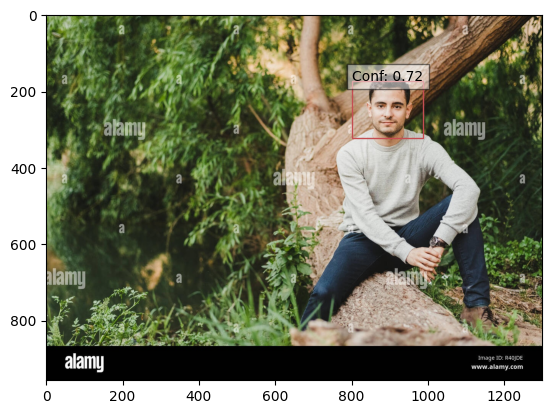

In [18]:
drawbox('/content/images/val/00000005.jpg')


0: 160x128 2 faces, 306.7ms
Speed: 1.0ms preprocess, 306.7ms inference, 2.4ms postprocess per image at shape (1, 3, 160, 128)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


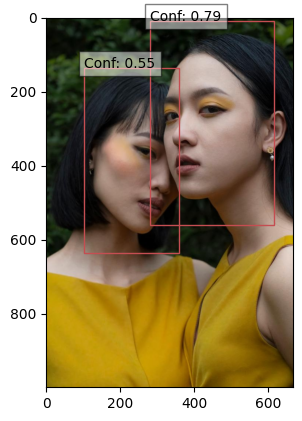

In [19]:
drawbox('/content/images/val/00000203.jpg')

In [20]:
model.export(format="onnx")

Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 160, 160) BCHW and output shape(s) (1, 5, 525) (49.6 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 166.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 13.6s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 16.1s, saved as 'runs/detect/train/weights/best.onnx' (98.6 MB)

Export complete (18.4s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=160  
Validate:        yolo val task=detect model=runs

'runs/detect/train/weights/best.onnx'

In [21]:
model.export(format="tflite")

Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 160, 160) BCHW and output shape(s) (1, 5, 525) (49.6 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 644.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 144.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 118.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.8/200.8 MB 134.9 MB/s eta 0:00:

100%|██████████| 1.11M/1.11M [00:00<00:00, 36.3MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 11.70file/s]


ONNX: starting export with onnx 1.16.1 opset 17...


ONNX: slimming with onnxslim 0.1.31...
ONNX: export success ✅ 6.5s, saved as 'runs/detect/train/weights/best.onnx' (98.7 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 100.6s, saved as 'runs/detect/train/weights/best_saved_model' (246.8 MB)

TensorFlow Lite: starting export with tensorflow 2.15.0...
TensorFlow Lite: export success ✅ 0.0s, saved as 'runs/detect/train/weights/best_saved_model/best_float32.tflite' (98.7 MB)

Export complete (105.4s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=160  
Validate:        yolo val task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=160 data=/content/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best_saved_model/best_float32.tflite'


0: 160x128 1 face, 17.3ms
Speed: 2.4ms preprocess, 17.3ms inference, 2.5ms postprocess per image at shape (1, 3, 160, 128)

0: 128x160 1 face, 36.1ms
Speed: 0.9ms preprocess, 36.1ms inference, 2.1ms postprocess per image at shape (1, 3, 128, 160)

0: 96x160 1 face, 160.2ms
Speed: 0.7ms preprocess, 160.2ms inference, 2.7ms postprocess per image at shape (1, 3, 96, 160)

0: 96x160 1 face, 19.1ms
Speed: 1.6ms preprocess, 19.1ms inference, 2.5ms postprocess per image at shape (1, 3, 96, 160)

0: 128x160 1 face, 24.6ms
Speed: 1.0ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 128, 160)

0: 128x160 (no detections), 17.4ms
Speed: 1.6ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 160)

0: 160x160 1 face, 18.8ms
Speed: 1.3ms preprocess, 18.8ms inference, 4.4ms postprocess per image at shape (1, 3, 160, 160)

0: 128x160 1 face, 26.6ms
Speed: 1.0ms preprocess, 26.6ms inference, 2.5ms postprocess per image at shape (1, 3, 128, 160)



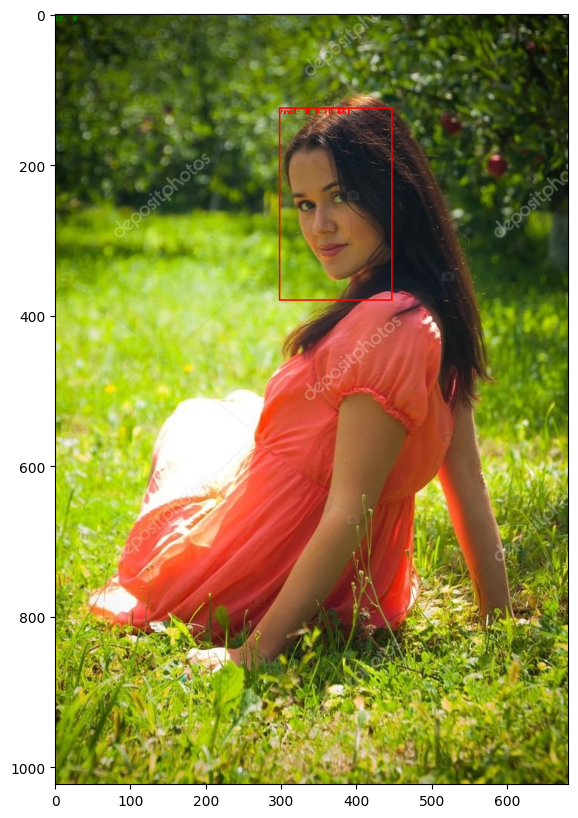

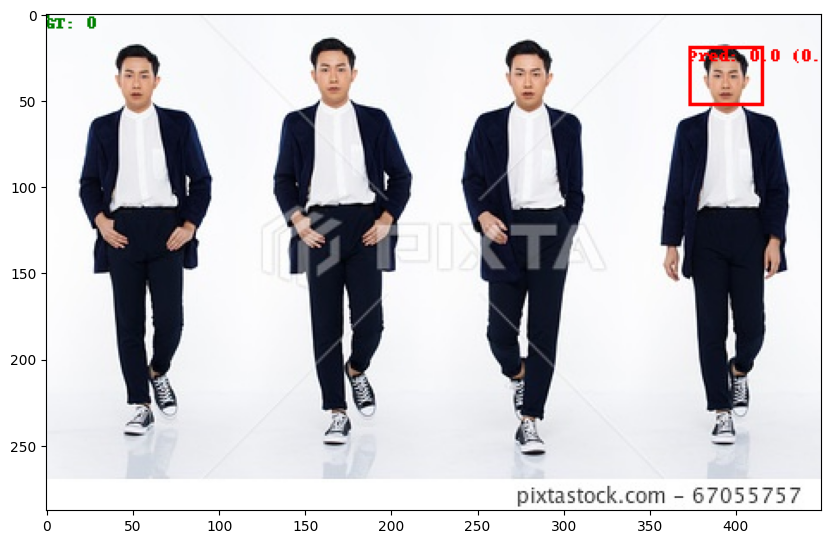

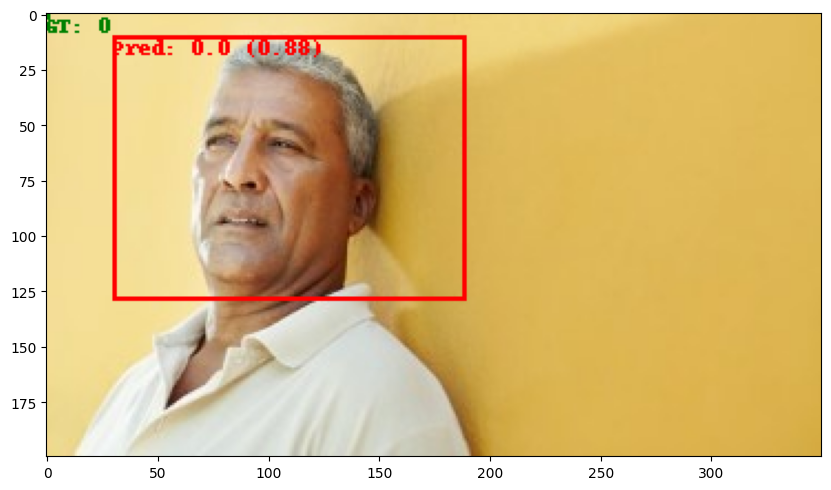

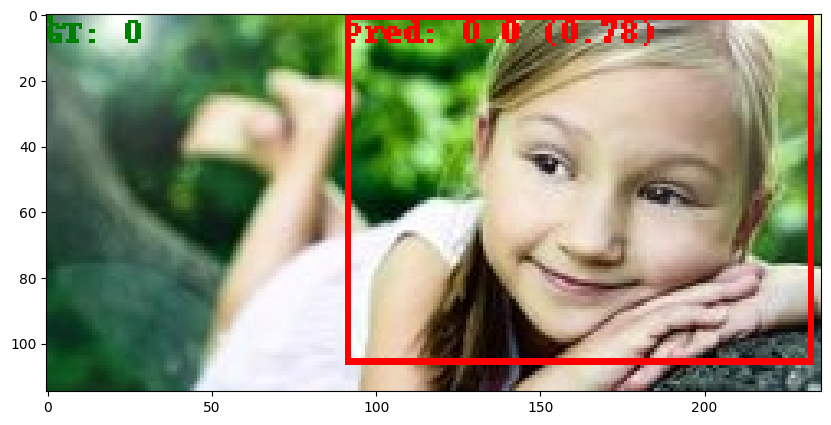

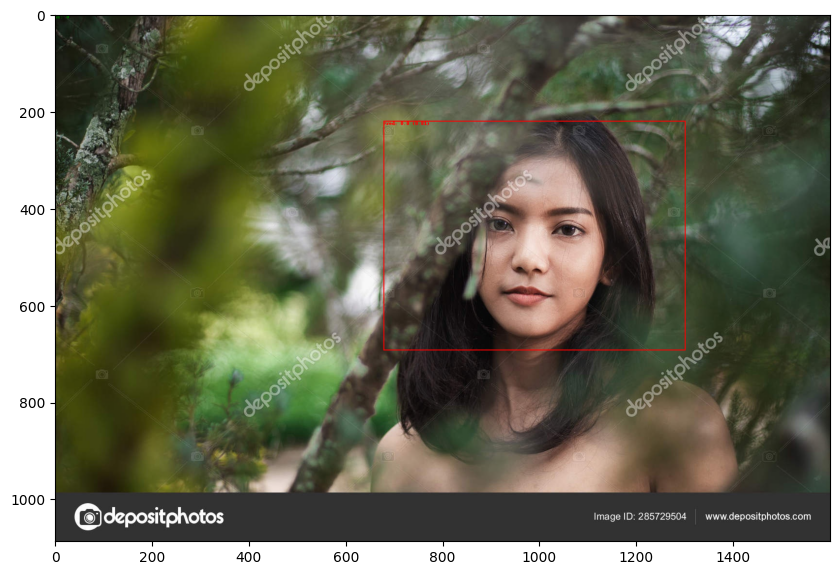

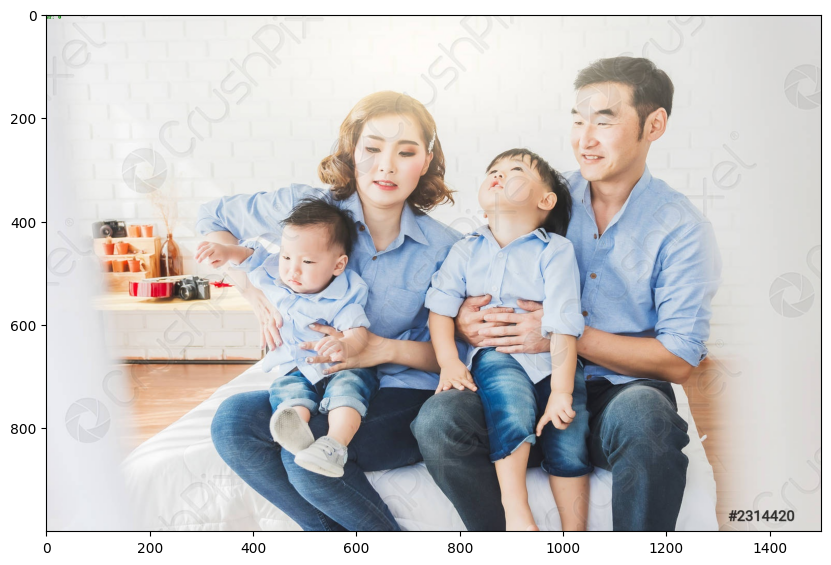

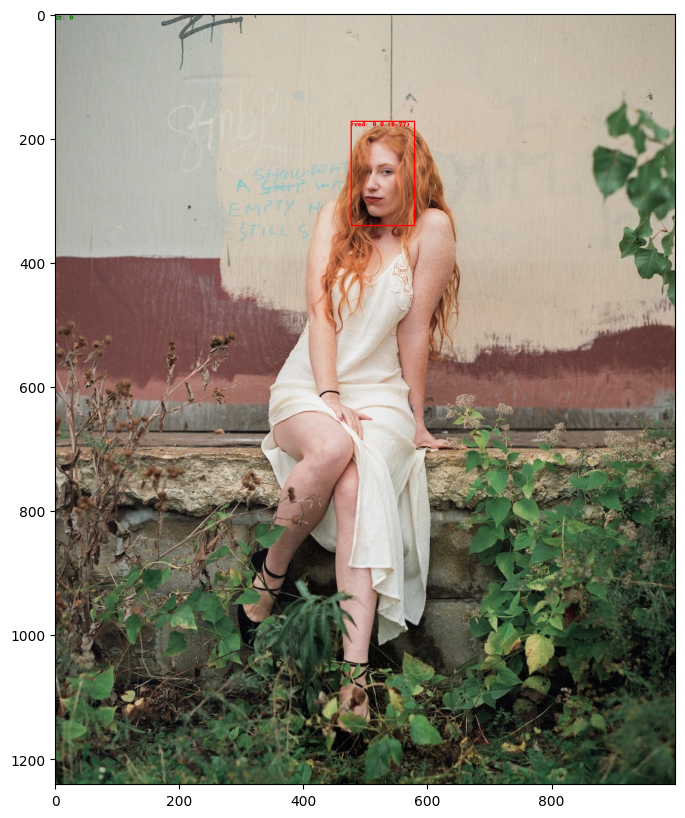

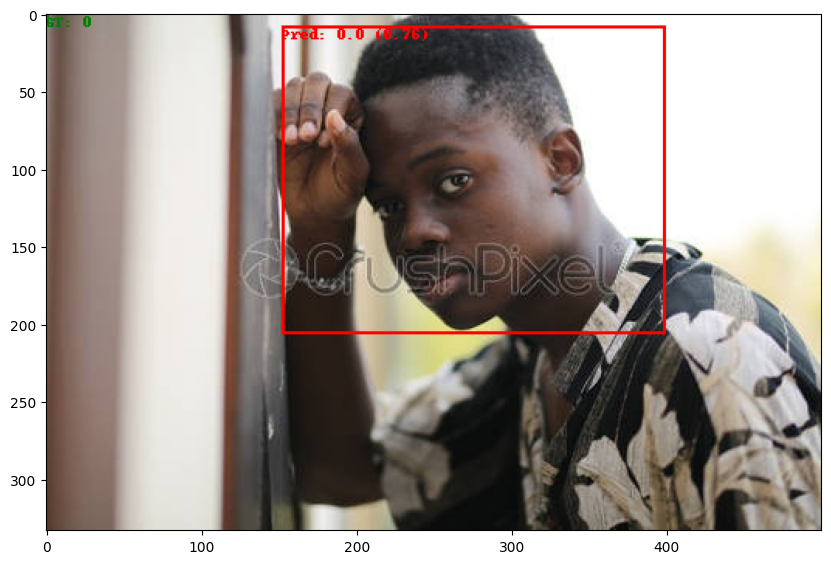

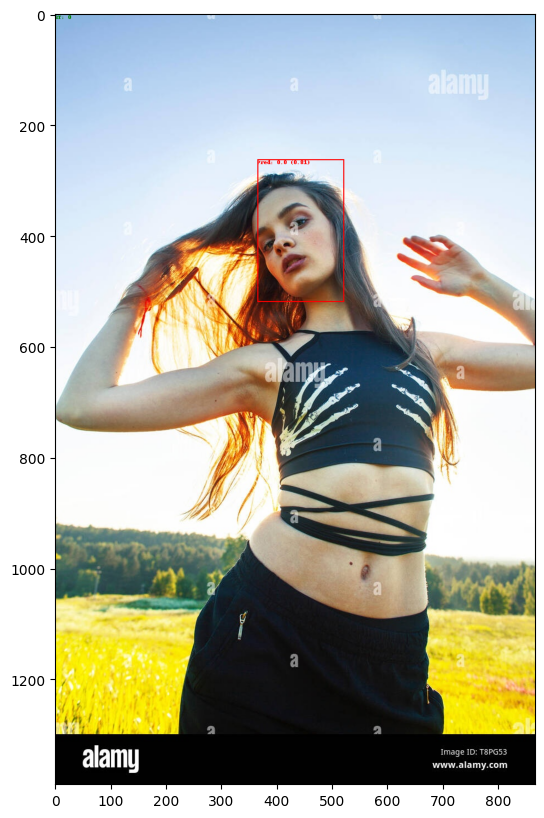

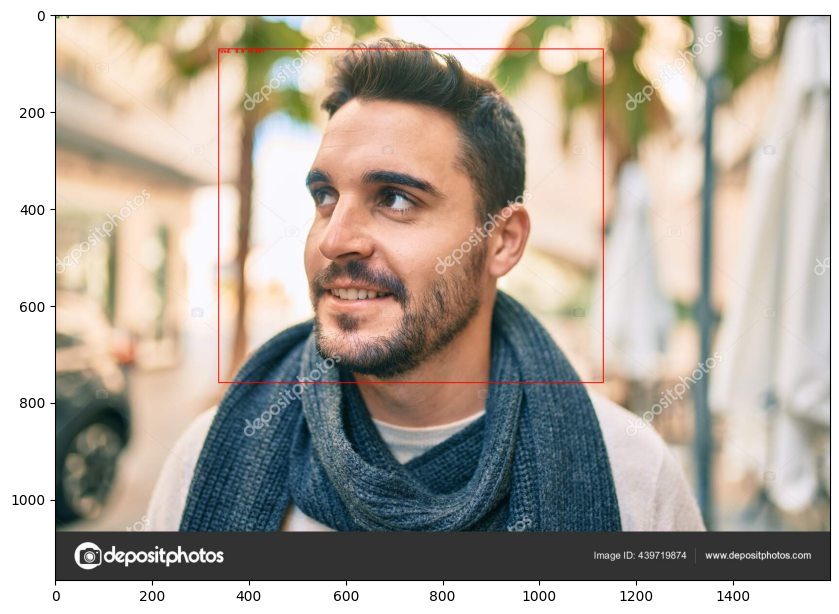

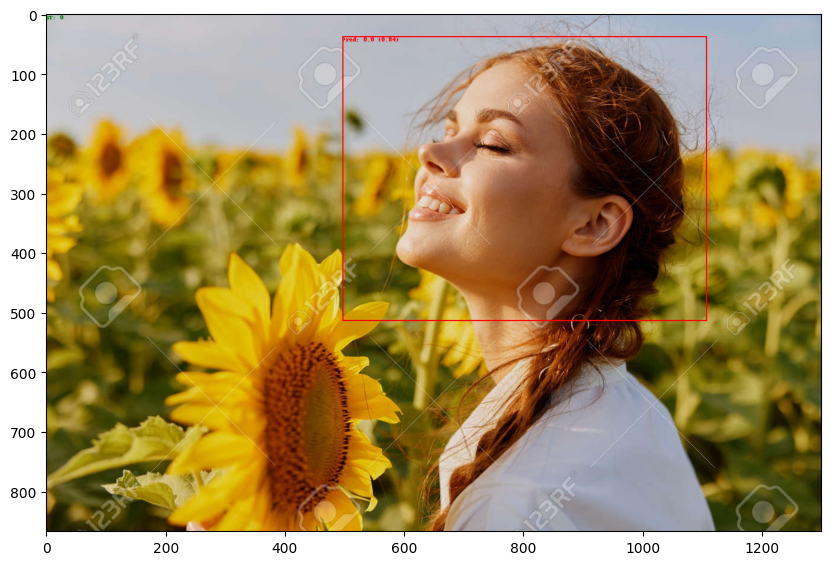

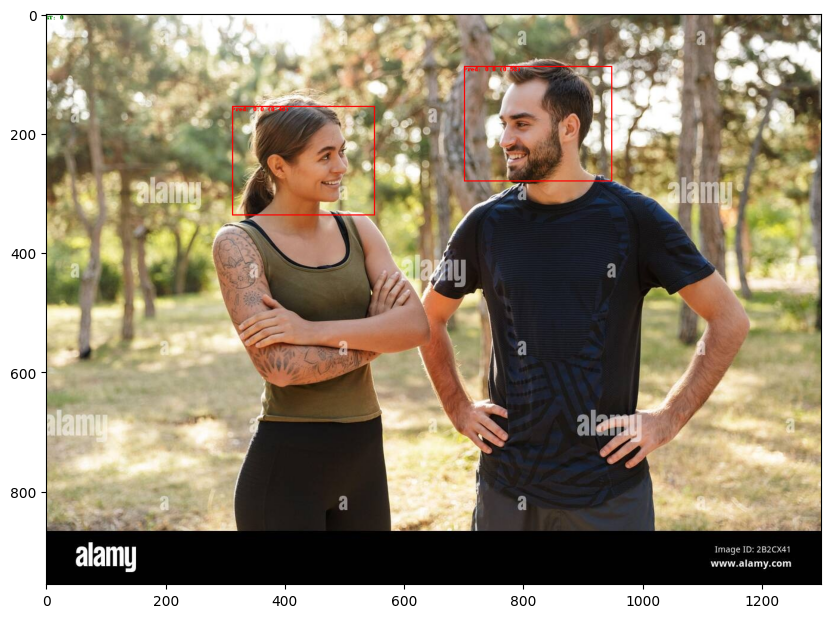

In [22]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Initialize the YOLO model
testmodel = YOLO("/content/runs/detect/train/weights/best.pt")

def load_ground_truth_labels(label_dir):
    labels = {}
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, 'r') as f:
                boxes = []
                for line in f:
                    parts = line.strip().split()
                    cls_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    xmin = x_center - width / 2
                    ymin = y_center - height / 2
                    xmax = x_center + width / 2
                    ymax = y_center + height / 2
                    boxes.append([xmin, ymin, xmax, ymax, cls_id])
                labels[label_file.replace('.txt', '.jpg')] = boxes
    return labels

def get_predictions(image_dir):
    predictions = {}
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        img = Image.open(image_path)
        results = testmodel.predict(img)
        preds = []
        for r in results:
            for box in r.boxes.data.tolist():
                xmin, ymin, xmax, ymax, conf, cls_id = box
                preds.append([xmin, ymin, xmax, ymax, conf, cls_id])
        predictions[image_file] = preds
    return predictions

def drawbox(image_path, ground_truth, predictions):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    # Draw ground truth boxes in green
    for box in ground_truth:
        xmin, ymin, xmax, ymax, cls_id = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="green", width=2)
        draw.text((xmin, ymin), f"GT: {cls_id}", fill="green")

    # Draw predicted boxes in red
    for box in predictions:
        xmin, ymin, xmax, ymax, conf, cls_id = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin), f"Pred: {cls_id} ({conf:.2f})", fill="red")

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

# Load ground truth labels
ground_truth_labels = load_ground_truth_labels('/content/labels/test')

# Get model predictions
predictions = get_predictions('/content/images/test')

# Draw boxes for a few images
for image_file in os.listdir('/content/images/test')[:12]:  # Limit to 5 images for display
    image_path = os.path.join('/content/images/test', image_file)
    gt_boxes = ground_truth_labels.get(image_file, [])
    pred_boxes = predictions.get(image_file, [])
    drawbox(image_path, gt_boxes, pred_boxes)


In [27]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [41]:
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [42]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [45]:
!scp -r /content/runs '/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/'
!ccp -r /content/images '/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/'
!scp -r /content/yolov8m.pt '/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/'
!scp -r /content/yolov8n.pt '/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/'
!scp -r /content/data.yaml '/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/'
!ccp -r /content/labels '/content/drive/MyDrive/dltest/doanchuyenganhcuoi/dataFace/'


/bin/bash: line 1: ccp: command not found
/bin/bash: line 1: ccp: command not found
